In [10]:
from datasets import load_dataset
from PIL import Image
from transformers import  ViTForImageClassification, ViTFeatureExtractor
from functools import partial
import torch
from evaluate import load

from computer_vision.vit_transformers.func.ultil import transform
from computer_vision.vit_transformers.grad_cam_interpret.modules import reshape_vit_huggingface, run_grad_cam_on_image

In [3]:
model_directory = './vit_beans'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_directory)
model = ViTForImageClassification.from_pretrained(model_directory, return_dict=False)

In [4]:
ds = load_dataset('beans')

Found cached dataset beans (C:/Users/Kevin/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
f = partial(transform, feature_extractor)
prepared_ds = ds.with_transform(f)
prepared_ds['test'][:]['pixel_values'].shape

torch.Size([128, 3, 224, 224])

In [6]:
with torch.no_grad():
    logits = model(prepared_ds['test'][:]['pixel_values'])
predicted = logits[0].argmax(-1)

In [7]:
metric = load('accuracy')
metric.add_batch(predictions=predicted, references=prepared_ds['test'][:]['labels'])
metric.compute()

{'accuracy': 0.921875}

In [30]:
with torch.no_grad():
    logits = model(prepared_ds['test'][:1]['pixel_values'])

In [31]:
logits

(tensor([[ 3.5101, -1.6322, -1.5754]]),)

In [24]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision import transforms

# grad_cam config
image_size = (224, 224)
image_resized = ds["test"]["image"][0].resize(image_size)
tensor_resized = transforms.ToTensor()(image_resized)

category_dict = dict((v, k) for k, v in model.config.id2label.items())
targets_for_gradcam = [ClassifierOutputTarget(v) for i, v in category_dict.items()]
target_layer_gradcam = model.vit.encoder.layer[-2].output
image_grad_cam = run_grad_cam_on_image(model=model,
                                       target_layer=target_layer_gradcam,
                                       targets_for_gradcam=targets_for_gradcam,
                                       input_tensor=tensor_resized,
                                       input_image=image_resized,
                                       reshape_transform=reshape_vit_huggingface)
display(Image.fromarray(image_grad_cam))

AttributeError: 'tuple' object has no attribute 'logits'

In [23]:
tensor_resized[None, :]

tensor([[[[0.4784, 0.4784, 0.4353,  ..., 0.3137, 0.3686, 0.4902],
          [0.4196, 0.4510, 0.4000,  ..., 0.3451, 0.3882, 0.5725],
          [0.4157, 0.4235, 0.4196,  ..., 0.2941, 0.5412, 0.7412],
          ...,
          [0.3333, 0.3333, 0.4000,  ..., 0.5294, 0.4549, 0.3765],
          [0.3451, 0.3176, 0.2980,  ..., 0.4235, 0.3961, 0.4000],
          [0.3922, 0.3725, 0.3922,  ..., 0.3961, 0.4118, 0.4157]],

         [[0.5922, 0.5961, 0.5608,  ..., 0.1765, 0.2039, 0.3098],
          [0.5451, 0.5843, 0.5412,  ..., 0.2078, 0.2235, 0.3882],
          [0.5529, 0.5686, 0.5725,  ..., 0.1569, 0.3765, 0.5569],
          ...,
          [0.1647, 0.1490, 0.2039,  ..., 0.3725, 0.3333, 0.3216],
          [0.1490, 0.1294, 0.1176,  ..., 0.3098, 0.2980, 0.3294],
          [0.1882, 0.1804, 0.2157,  ..., 0.3098, 0.3412, 0.3529]],

         [[0.2039, 0.2157, 0.1686,  ..., 0.0667, 0.0745, 0.1725],
          [0.1373, 0.1765, 0.1216,  ..., 0.0902, 0.0941, 0.2510],
          [0.1490, 0.1529, 0.1333,  ..., 0

In [40]:
from pytorch_grad_cam import GradCAM
from pytorch_lightning import LightningModule
from torch import Tensor
import numpy as np
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2


def reshape_vit_huggingface(x):
    """
    Reshaping to features with the format: batch x features x height x width
    Transformers will sometimes have an internal shape that looks like this:
    (batch=10 x (tokens=145) x (features=384).
    The 145 tokens mean 1 CLS token + 144 spatial tokens.
    These 144 spatial tokens actually represent a 12x12 2D image.
    """
    # Remove the CLS token
    activations = x[:, 1:, :]
    image_2d_shape = int(np.sqrt(activations.shape[1]))
    # Reshape to a 12 x 12 spatial image:
    activations = activations.view(activations.shape[0], image_2d_shape, image_2d_shape, activations.shape[2])
    # Transpose the features to be in the second coordinate:
    activations = activations.transpose(2, 3).transpose(1, 2)
    return activations


class HuggingfaceWrapper(LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)[0]


cam = GradCAM(model=model,
             target_layers=[target_layer_gradcam],
             reshape_transform=reshape_vit_huggingface)

# Replicate the tensor for each of the categories we want to create Grad-CAM for:
repeated_tensor = tensor_resized[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)
batch_results = cam(input_tensor=repeated_tensor, targets=targets_for_gradcam)

# Results
results = []
for grayscale_cam in batch_results:
    visualization = show_cam_on_image(np.float32(image_resized) / 255, grayscale_cam, use_rgb=True)
    # Make it weight less in the notebook:
    visualization = cv2.resize(visualization, (visualization.shape[1] // 2, visualization.shape[0] // 2))
    results.append(visualization)

RuntimeError: grad can be implicitly created only for scalar outputs

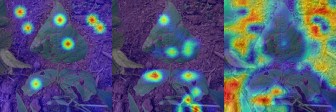

In [37]:
display(Image.fromarray(np.hstack(results)))